### 风险模型 - 债券违约风险评估
杜佳阳

#### Import necessary libraries

In [106]:
#import necessary libraries
import numpy as np 
import pandas as pd

from scipy import stats  #for some statistics
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

import warnings 
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn  #ignore warnings (from sklearn and seaborn)

#### labelling 

#### Downgrade Marking
A company is marked as 1 if its rating is downgraded from AA or above (including AA) to below AA within a year of the annual report date; otherwise, it is marked as 0.

Note:

- Only downgrades to below AA are considered; other downgrades are disregarded.
- Time concept: Rating changes within a year after the annual report date.
- Criterion: If a company has multiple records within a year, it is classified as downgraded if at least one record shows the aforementioned downgrade.

标记降级
在年报日期一年内，评级从AA以上（包含AA)下调到AA以下的公司被标为1，否则标为0.

注意：
- 只关注评级跌倒AA以下的下调，其他下调不在乎
- 时间概念：在年报日期之后一年内的评级变化
- 标准：若某公司在一年内有多条记录，只要有一条以上记录是上述的下调我们则将其归为下调

In [107]:
data = pd.read_csv('/Users/jiayangdu/Desktop/PWC/Rating Analysis/ratings.csv')
goodratings = ['AAA','Aa1','Aa2','AAA-','AA+','AA']
data = data.dropna(how='any')

data['B_INFO_CREDITRATING2'] = data['B_INFO_CREDITRATING'].apply(lambda x:
    1 if x in goodratings else 0)

data['B_INFO_PRECREDITRATING2'] = data['B_INFO_PRECREDITRATING'].apply(lambda x:
    1 if x in goodratings else 0)

data['label'] = data['B_INFO_PRECREDITRATING2'] - data['B_INFO_CREDITRATING2']

# ----------------------------

data_downgrade = data.loc[data['label'] == 1]

def func(company,date): # data里面 [company] 在这个日期 [之后一年]评级是否下调，下调返回1
    # date:2013 年报的年份
    x = data_downgrade.loc[data_downgrade['S_INFO_COMPCODE'] == company]
    if len(x)>0:
        # a:20130601 -> 2013 -> 2012年报信息
        x = x.loc[x['ANN_DT'].apply(lambda a: True if date+1 >= a//10000 > date else False)]
        if len(x) > 0:
            return 1
        return 0
    else:
        return 0

def func1(company,date): # data 里面选出[company]在这个日期[之前][最近的]评级是否为good，好公司返回true
    # data : 2012
    # ANN_DT: 20131201
    x = data.loc[data['S_INFO_COMPCODE']==company]
    if len(x)>0:
        x = x.loc[x['ANN_DT'].apply(lambda a: True if a//10000 <= date else False)]
        if len(x) > 0:
            x = x.sort_values(by='ANN_DT')
            return x.iloc[-1]['B_INFO_CREDITRATING'] in goodratings
        else:
            return False
    else:
        return False

# 示例数据
features_all = pd.DataFrame()
for year in [2011,2012,2013,2014,2015,2016,2017]:
    tempdata = pd.read_csv('/Users/jiayangdu/Desktop/PWC/Rating Analysis/report_{}1231.csv'.format(year), index_col=0)
    tempdata['date'] = year
    tempdata.fillna(0, inplace=True) # 用0填非值
    features_all = pd.concat([features_all,tempdata], axis=0)


# 选出之前评级在2A以上的公司
print('step1')
features_all = features_all.loc[
    features_all.apply(lambda row: func1(row.name,row['date']), axis=1)]

# 把之前评级在2A以上，后续在2A以下的公司打1
print('step2')
features_all['label'] = features_all.apply(lambda row: func(row.name,row['date']), axis=1)

step1
step2


#### feature construct

#### Feature Construct
The focus here is primarily on the eight factors within the Beneish Model, in addition to other commonly used accounting indicators.

All non-values have been filled in with 0.

创建因子
这里主要关注benish model里面的8个因子，此外还创建了其他的常用的会计指标。

此处非值都被填0

In [108]:
##########feature construct##########
def nandivide(a,b):
    b = b.apply(lambda x:np.nan if x==0 else x)
    r = a/b 
    return r.fillna(0)

# 1 Net Receivables
features_all['Net Receivables'] = (features_all['NOTES_RCV']
                                +features_all['ACCT_RCV']
                                +features_all['OTH_RCV']
                                +features_all['DVD_RCV']
                                +features_all['INT_RCV']
                                -features_all['NOTES_PAYABLE']
                                -features_all['ACCT_PAYABLE']
                                -features_all['ADV_FROM_CUST'])
# 2~4                   
features_all['Current Assets'] = features_all['TOT_CUR_ASSETS']
features_all['Total Assets'] = features_all['TOT_ASSETS']
features_all['Current Liabilities'] = features_all['TOT_CUR_LIAB']

# 5 Total Long Term Debt
features_all['Total Long Term Debt'] = (features_all['LT_BORROW']
                                    +features_all['BONDS_PAYABLE']
                                    +features_all['LT_PAYABLE'])

# 6 PP&E
features_all['PP&E'] = features_all['FIX_ASSETS']
features_all['PP&E'] = (features_all['FIX_ASSETS']
                    +features_all['CONST_IN_PROG']
                    +features_all['INVEST_REAL_ESTATE']
                    +features_all['PROJ_MATL']
                    +features_all['OIL_AND_NATURAL_GAS_ASSETS']
                    +features_all['PRODUCTIVE_BIO_ASSETS'])

# 7 Securities
features_all['Securities'] = (features_all['FIN_ASSETS_AVAIL_FOR_SALE'] 
                              + features_all['TRADABLE_FIN_ASSETS'])

# 8~9
features_all['Depreciation'] = features_all['DEPR_FA_COGA_DPBA']
features_all['Cash Flows from Operations'] = features_all['NET_CASH_FLOWS_OPER_ACT']

# 10,11
features_all['Sales'] = features_all['TOT_OPER_REV']
features_all['COGS'] = features_all['LESS_OPER_COST']

# 12 SG&A Expense
features_all['SG&A Expense'] = (features_all['LESS_SELLING_DIST_EXP']
                            +features_all['LESS_GERL_ADMIN_EXP'])

# 13
features_all['Income from Continuing Operations'] = features_all['OPER_PROFIT']

# others
features_all['ds'] = nandivide(features_all['Net Receivables'],features_all['Sales'])
features_all['gm'] = nandivide((features_all['Sales']-features_all['COGS']),features_all['Sales'])
features_all['aq'] = nandivide(features_all['Total Assets']-(features_all['Current Assets']+features_all['PP&E']+features_all['Securities']),features_all['Total Assets'])
features_all['de'] = nandivide(features_all['Depreciation'],(features_all['PP&E']+features_all['Depreciation']))
features_all['sg'] = nandivide(features_all['SG&A Expense'],features_all['Sales'])
features_all['lv'] = nandivide((features_all['Current Liabilities']+features_all['Total Long Term Debt']),features_all['Total Assets'])
features_all['TATA'] = nandivide((features_all['Income from Continuing Operations']-features_all['Cash Flows from Operations']),features_all['Total Assets'])
features_all['XueIdx_1'] = nandivide((features_all['OPER_PROFIT']+features_all['LESS_FIN_EXP']+features_all['DEPR_FA_COGA_DPBA']+features_all['AMORT_INTANG_ASSETS']),features_all['TOT_LIAB'])
features_all['XueIdx_3'] = nandivide((features_all['TOT_PROFIT']- features_all['OPER_PROFIT']),features_all['TOT_PROFIT'].apply(lambda x: np.nan if x<=0 else x))
features_all['XueIdx_4'] = nandivide((features_all['ACCT_RCV']+features_all['NOTES_RCV']+features_all['OTH_RCV']),features_all['TOT_CUR_ASSETS'])  
features_all['LOSS'] = (features_all['TOT_PROFIT']-features_all['PLUS_NON_OPER_REV']+features_all['LESS_NON_OPER_EXP']).apply(lambda x: 1 if x<0 else 0)
features_all['OTHREC'] = nandivide(features_all['OTH_RCV'],features_all['TOT_ASSETS'])
features_all['size'] = features_all['TOT_ASSETS'].apply(float)
features_all['equity'] = features_all['TOT_ASSETS']-features_all['TOT_LIAB']
features_all['cfi'] = nandivide(features_all['NET_CASH_FLOWS_INV_ACT'],features_all['NET_CASH_FLOWS_OPER_ACT'].apply(abs))
features_all['cff'] = nandivide(features_all['NET_CASH_FLOWS_FNC_ACT'],features_all['NET_CASH_FLOWS_OPER_ACT'].apply(abs))
features_all['lin1'] =nandivide(features_all['OTHER_CASH_RECP_RAL_FNC_ACT'],features_all['TOT_ASSETS'])
features_all['Cash Flows from Operations'] = features_all['NET_CASH_FLOWS_OPER_ACT']
features_all['lin2'] =nandivide(features_all['TOT_CUR_LIAB'],features_all['Cash Flows from Operations'].apply(abs))
features_all['Sales'] = features_all['TOT_OPER_REV']
features_all['lin_1'] = nandivide(features_all['Sales']-features_all['Cash Flows from Operations'],features_all['Sales'])
features_all['turnover'] = nandivide(features_all['Sales'],features_all['INVENTORIES'])
features_all['lin_5'] = nandivide(features_all['INVENTORIES'],features_all['TOT_ASSETS'])

In [109]:
## 跨时期
#####Benish model Index###########
for year in [2011,2012,2013,2014,2015,2016,2017]:
    idx1 = features_all['date'] == year
    idx2 = features_all['date'] == year - 1

    features_all.loc[idx1,'DSRI'] = nandivide(features_all.loc[idx1,'ds'],features_all.loc[idx2,'ds'])   
    features_all.loc[idx1,'GMI'] = nandivide(features_all.loc[idx1,'gm'],features_all.loc[idx2,'gm'])
    features_all.loc[idx1,'AQI'] = nandivide(features_all.loc[idx1,'aq'],features_all.loc[idx2,'aq'])
    features_all.loc[idx1,'SGI'] = nandivide(features_all.loc[idx1,'Sales']-features_all.loc[idx2,'Sales'],features_all.loc[idx2,'Sales'])
    features_all.loc[idx1,'DEPI'] = nandivide(features_all.loc[idx2,'de'],features_all.loc[idx1,'de'])
    features_all.loc[idx1,'SGAI'] = nandivide(features_all.loc[idx1,'sg'],features_all.loc[idx2,'sg'])
    features_all.loc[idx1,'LVGI'] = nandivide(features_all.loc[idx1,'lv'],features_all.loc[idx2,'lv'])

    features_all.loc[idx1,'ac_chg'] = (features_all.loc[idx1,'ACCT_RCV']+features_all.loc[idx1,'NOTES_RCV']) - (features_all.loc[idx2,'ACCT_RCV']+features_all.loc[idx2,'NOTES_RCV'])
    features_all.loc[idx1,'cash'] = features_all.loc[idx1,'MONETARY_CAP']-features_all.loc[idx2,'MONETARY_CAP']

    features_all.loc[idx1,'XueIdx_2'] = nandivide(features_all.loc[idx1,'cash'],
                    features_all.loc[idx1,'NON_CUR_LIAB_DUE_WITHIN_1Y']+
                    features_all.loc[idx1,'ST_BORROW']+
                    features_all.loc[idx1,'OTH_PAYABLE']+
                    features_all.loc[idx1,'ACCT_PAYABLE']+
                    features_all.loc[idx1,'NOTES_PAYABLE'])
    features_all.loc[idx1,'CH_CS'] = nandivide(features_all.loc[idx1,'OPER_PROFIT']-features_all.loc[idx1,'ac_chg'],features_all.loc[idx1,'TOT_OPER_REV'])          
    features_all.loc[idx1,'fcf'] = nandivide(features_all.loc[idx1,'free_cash_flow'] - features_all.loc[idx2,'free_cash_flow'],features_all.loc[idx2,'free_cash_flow'].apply(abs))

    features_all.loc[idx1,'lin3'] = nandivide(features_all.loc[idx1,'STOT_CASH_INFLOWS_INV_ACT'],
                                features_all.loc[idx2,'STOT_CASH_INFLOWS_INV_ACT'])
    features_all.loc[idx1,'lin4'] = nandivide(features_all.loc[idx1,'OPER_PROFIT'],features_all.loc[idx2,'OPER_PROFIT'])

features_all.fillna(0)

,ACCT_PAYABLE,ACCT_RCV,ADV_FROM_CUST,AMORT_INTANG_ASSETS,BONDS_PAYABLE,CONST_IN_PROG,DEPR_FA_COGA_DPBA,DVD_RCV,FIN_ASSETS_AVAIL_FOR_SALE,FIX_ASSETS,...,DEPI,SGAI,LVGI,ac_chg,cash,XueIdx_2,CH_CS,fcf,lin3,lin4
1000878,1.889530e+09,5.757621e+08,1.141516e+09,1.117539e+08,0.000000e+00,1.434562e+09,6.248458e+08,1.083224e+06,0.000000e+00,7.471991e+09,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
0PN7664A78,1.276098e+10,5.890944e+09,3.361160e+09,1.247985e+08,2.069182e+10,1.114405e+10,3.403542e+09,5.472928e+08,3.450181e+08,6.149382e+10,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
48O4F17231,4.878329e+08,1.256955e+07,5.763969e+08,1.797120e+06,3.064767e+09,5.177471e+09,1.170368e+08,1.756802e+07,0.000000e+00,1.952379e+10,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
0MG85D045B,5.956188e+09,2.188731e+09,1.221882e+09,1.040204e+08,4.743699e+09,5.762845e+09,2.023151e+09,8.129142e+06,5.263104e+07,2.055144e+10,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
48B910F2D3,5.961835e+08,7.556131e+07,1.047031e+08,1.674159e+06,8.000000e+08,4.547756e+09,1.186000e+07,0.000000e+00,0.000000e+00,1.786416e+08,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g0oUr9ECup,2.668164e+08,2.452434e+08,2.499697e+08,4.036051e+06,4.000000e+08,1.197482e+09,4.599625e+07,0.000000e+00,3.715278e+08,4.423229e+08,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2AF4DF7DDD,4.078390e+08,8.082232e+08,7.998753e+07,1.551297e+07,8.956964e+08,8.589708e+08,8.984882e+07,0.000000e+00,3.196500e+08,1.539687e+09,...,0.805774,1.022760,1.075361,4.506037e+06,5.780043e+08,0.252942,0.046195,-0.641654,1.141887,1.782636
d47n41QHbj,5.739578e+09,1.659649e+09,1.578367e+09,4.148514e+07,6.305757e+09,3.584025e+09,1.924509e+09,0.000000e+00,4.460654e+08,3.413655e+10,...,1.157305,0.692584,1.040091,1.416832e+09,2.164571e+09,0.075109,0.025915,30.504633,36.022738,1.522097
2NP032D265,6.299960e+08,4.821553e+07,3.682852e+08,1.351723e+06,1.300000e+10,1.137292e+10,1.686825e+09,0.000000e+00,8.110000e+07,9.612756e+10,...,0.966608,1.213870,1.007777,-6.621488e+06,2.152419e+09,0.232775,2.375305,1.018360,3.962463,-2.918715


#### Binning continuous variable

##### 装箱编码：
将除了label意外的其他连续变量，分成同等的10份编码装箱

In [113]:
#binning all continuous variable except label
features_except_label= features_all.drop(['label'], axis=1)
for col in features_except_label.columns:
    features_all[col] = pd.qcut(features_all[col],10,duplicates='drop',labels=False)

#### Define Evaluation

##### Subsequent model performance is primarily assessed by the confusion matrix and ROC curve.
之后的模型表现主要由confusion matrix 和 roc curve评估

In [151]:
##########定义roc图和confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc

def illus_roc_curve(real,pred):
    # Compute ROC curve and ROC area for each class 
    
    fpr,tpr,threshold = roc_curve(real, pred) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label'])
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('\nPrecision: {}'.format(Precision))
    print('Recall: {}\n'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'False':FalseNegative,'True':TrueNegative},
                    'Positive':{'False':FalsePositive,'True':TruePositive}                            
                    })      
    
    print(_confusion_matrix)
    return _confusion_matrix

##### classification distribution

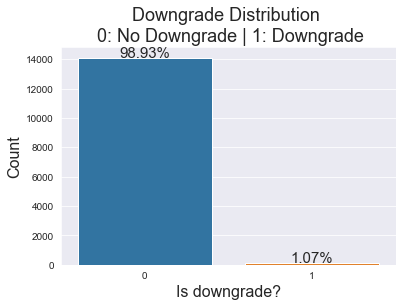

In [174]:
##visulization for label distribution
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plot_tr = sns.countplot(x='label', data=features_all)
plot_tr.set_title("Downgrade Distribution \n 0: No Downgrade | 1: Downgrade", fontsize=18)
plot_tr.set_xlabel("Is downgrade?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
total = len(features_all)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

#### Model 1: Logistic Regression

In [120]:
reg_cols = ['AQI',
            'DSRI',
            'GMI',
            'LVGI',
            'SGAI',
            'SGI',
            'TATA',
            'XueIdx_1',
            'XueIdx_3',
            'XueIdx_4',
            'LOSS',
            'OTHREC',
            'size',
            'equity',
            'cfi',
            'cff',
            'lin1',
            'lin2',
            'lin_1',
            'turnover',
            'lin_5']
x = features_all[reg_cols]
y = x.corr()

In [121]:
y

,AQI,DSRI,GMI,LVGI,SGAI,SGI,TATA,XueIdx_1,XueIdx_3,XueIdx_4,...,OTHREC,size,equity,cfi,cff,lin1,lin2,lin_1,turnover,lin_5
AQI,1.000000,0.456947,0.569712,0.465914,0.576997,0.250616,-0.131993,0.041778,-0.058856,0.030580,...,-0.073403,0.170435,0.157706,-0.005492,-0.107154,0.096327,0.047499,-0.082549,0.208402,0.018425
DSRI,0.456947,1.000000,0.516091,0.515004,0.605777,0.038370,-0.039248,-0.046627,0.027820,0.083867,...,0.072906,0.133127,0.128760,0.017807,-0.038696,0.104721,0.042577,-0.003647,0.091052,0.099390
GMI,0.569712,0.516091,1.000000,0.467702,0.664931,0.169695,-0.102657,0.099427,-0.048599,0.016899,...,-0.048546,0.146870,0.139230,0.035014,-0.104894,0.088789,0.023637,-0.089107,0.187037,0.044241
LVGI,0.465914,0.515004,0.467702,1.000000,0.534165,0.254700,0.017777,-0.119339,0.031328,0.036786,...,0.080739,0.140078,0.114287,-0.083999,0.149577,0.114135,0.095662,0.075457,0.073258,0.131947
SGAI,0.576997,0.605777,0.664931,0.534165,1.000000,-0.087786,-0.102491,-0.003347,-0.005339,0.044234,...,-0.010479,0.140438,0.132244,0.010780,-0.065575,0.100068,0.062718,-0.048774,0.163332,0.065580
SGI,0.250616,0.038370,0.169695,0.254700,-0.087786,1.000000,0.026427,0.095973,-0.047161,-0.029912,...,-0.026013,0.133375,0.133387,-0.078052,0.075276,0.062302,0.023168,-0.004994,0.125909,0.022001
TATA,-0.131993,-0.039248,-0.102657,0.017777,-0.102491,0.026427,1.000000,-0.091515,-0.039981,-0.065036,...,0.212162,-0.017623,0.024874,0.042235,0.355150,0.047148,0.126718,0.744006,-0.295433,0.285043
XueIdx_1,0.041778,-0.046627,0.099427,-0.119339,-0.003347,0.095973,-0.091515,1.000000,-0.357570,0.042107,...,-0.453681,-0.123345,-0.093378,-0.011303,-0.234367,-0.159586,-0.107813,-0.211633,0.529373,-0.349753
XueIdx_3,-0.058856,0.027820,-0.048599,0.031328,-0.005339,-0.047161,-0.039981,-0.357570,1.000000,0.077772,...,0.247716,-0.027981,0.022162,-0.068281,0.123717,0.072874,0.033536,0.072050,-0.186195,0.133374
XueIdx_4,0.030580,0.083867,0.016899,0.036786,0.044234,-0.029912,-0.065036,0.042107,0.077772,1.000000,...,0.375863,-0.069587,-0.098397,-0.072087,-0.048653,0.071668,0.124183,-0.002066,0.259278,-0.276371


In [122]:
# drop Loss
import statsmodels.api as sm
reg_cols = ['AQI','DSRI','GMI','LVGI','SGAI','SGI','TATA','XueIdx_1','XueIdx_3','XueIdx_4','OTHREC','size','equity','cfi','cff','lin1','lin2','lin_1','turnover','lin_5']
logit = sm.Logit(features_all['label'], features_all[reg_cols])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.044333
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                14249
Model:                          Logit   Df Residuals:                    14229
Method:                           MLE   Df Model:                           19
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:                  0.2492
Time:                        16:07:53   Log-Likelihood:                -631.70
converged:                       True   LL-Null:                       -841.35
Covariance Type:            nonrobust   LLR p-value:                 4.213e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AQI            0.0336      0.042      0.798      0.425      -0.049       0.116
DSRI          -0.0015      0

In [124]:
reg_cols = ['GMI','LVGI','SGI','TATA','XueIdx_1','XueIdx_3','XueIdx_4','OTHREC','size','equity','cfi','cff','lin1','lin_1']
logit = sm.Logit(features_all['label'], features_all[reg_cols])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.044492
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                14249
Model:                          Logit   Df Residuals:                    14235
Method:                           MLE   Df Model:                           13
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:                  0.2465
Time:                        16:09:08   Log-Likelihood:                -633.97
converged:                       True   LL-Null:                       -841.35
Covariance Type:            nonrobust   LLR p-value:                 1.693e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GMI           -0.1022      0.036     -2.862      0.004      -0.172      -0.032
LVGI           0.1007      0

In [125]:
pred = result.predict(features_all[reg_cols]) #生成预测值
for t in [1e-5,1e-4,1e-3,1e-2]:
    print(t)
    pred2 = pred.apply(lambda x: 1 if x>t else 0)
    real = features_all['label']
    confusion_matrix(pred2,real)

1e-05

Precision: 0.010667415257211032
Recall: 1.0

       Negative  Positive
False         0     14097
True          0       152
0.0001

Precision: 0.010692930003517412
Recall: 1.0

       Negative  Positive
False         0     14063
True         34       152
0.001

Precision: 0.013618859772705926
Recall: 0.9539473684210527

       Negative  Positive
False         7     10502
True       3595       145
0.01

Precision: 0.040273282991729595
Recall: 0.7368421052631579

       Negative  Positive
False        40      2669
True      11428       112


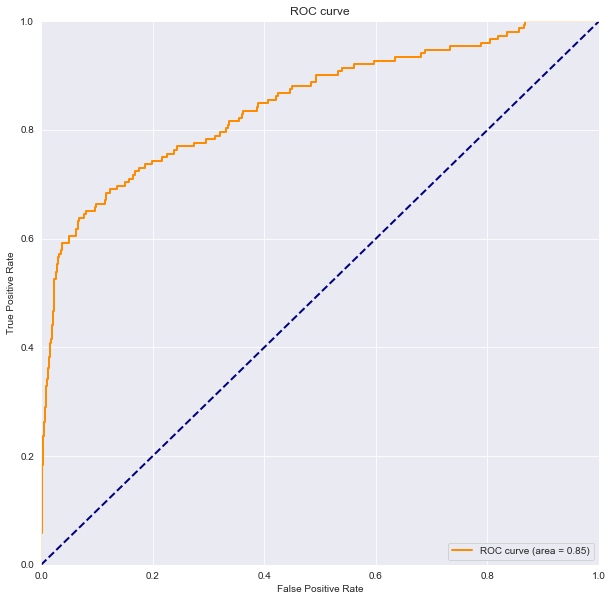

In [126]:
illus_roc_curve(real,pred)

#### Model 2: Decision Tree

reference：

https://www.cnblogs.com/tangxiaobo199181/p/12227543.html

https://zhuanlan.zhihu.com/p/108628169

https://blog.csdn.net/xbinworld/article/details/44660339

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://blog.csdn.net/qq_38923076/article/details/82931340

In [127]:
#train test split
from sklearn.model_selection import train_test_split
reg_cols = ['AQI',
            'DSRI',
            'GMI',
            'LVGI',
            'SGAI',
            'SGI',
            'TATA',
            'XueIdx_1',
            'XueIdx_3',
            'XueIdx_4',
            'LOSS',
            'OTHREC',
            'size',
            'equity',
            'cfi',
            'cff',
            'lin1',
            'lin2',
            'lin_1',
            'turnover',
            'lin_5']

y = features_all['label']
X = features_all[reg_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

In [128]:
# define decision tree (basic)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

#fit
r = dt.fit(X_train,y_train)

#predict
y_pred_train= dt.predict(X_train)
y_pred_test = dt.predict(X_test)

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems.

In [129]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5590244362675724

In [130]:
# confusion_matrix(y_pred_train, y_train)
confusion_matrix(y_pred_test, y_test)


Precision: 0.06896551724137931
Recall: 0.13333333333333333

       Negative  Positive
False        26        54
True       3479         4


,Negative,Positive
False,26,54
True,3479,4


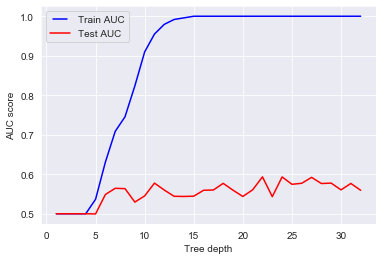

In [132]:
#parameter tuning
#max_depth: This indicates how deep the tree can be. 
#The deeper the tree, the more splits it has and it captures more information about the data. 
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data

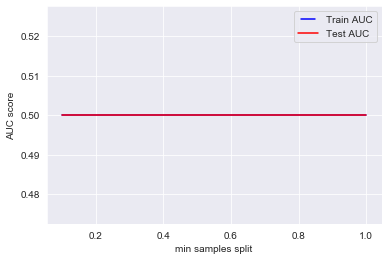

In [133]:
#min_samples_split represents the minimum number of samples required to split an internal node. 
#When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. 
#Here we will vary the parameter from 10% to 100% of the samples
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

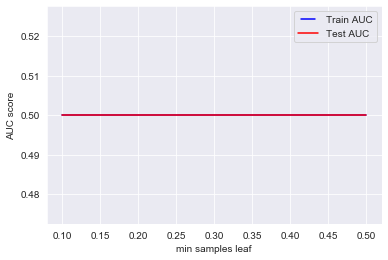

In [134]:
#min_samples_leaf is The minimum number of samples required to be at a leaf node.
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

#### Model 3: Random Forest

reference:

https://www.jiqizhixin.com/articles/2017-07-31-3

https://easyai.tech/ai-definition/random-forest/

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

https://blog.csdn.net/qq547276542/article/details/78304454

https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

In [170]:
from sklearn.model_selection import train_test_split
reg_cols = ['AQI',
            'DSRI',
            'GMI',
            'LVGI',
            'SGAI',
            'SGI',
            'TATA',
            'XueIdx_1',
            'XueIdx_3',
            'XueIdx_4',
            'LOSS',
            'OTHREC',
            'size',
            'equity',
            'cfi',
            'cff',
            'lin1',
            'lin2',
            'lin_1',
            'turnover',
            'lin_5']

y = features_all['label']
X = features_all[reg_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

In [171]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
r = rf.fit(X_train,y_train)
y_pred_train= rf.predict(X_train)
y_pred_test = rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3533
           1       0.00      0.00      0.00        30

    accuracy                           0.99      3563
   macro avg       0.50      0.50      0.50      3563
weighted avg       0.98      0.99      0.99      3563

预估结果的ROC图:


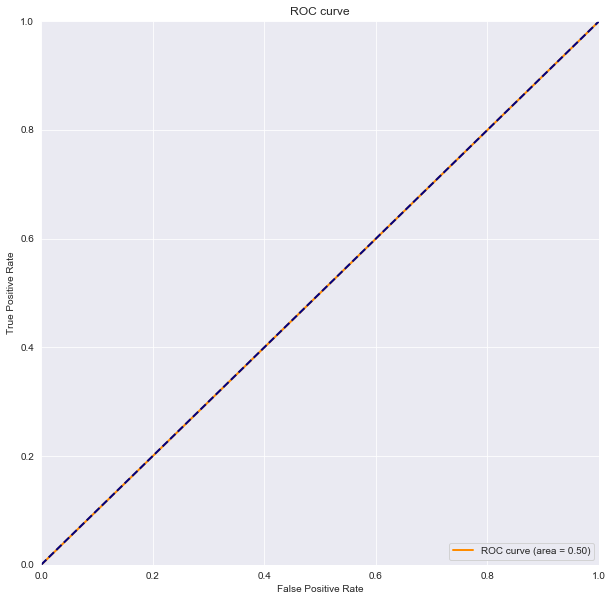

In [172]:
# confusion_matrix(y_pred_train, y_train)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred_test))
print('预估结果的ROC图:')
illus_roc_curve(y_test,y_pred_test)

In [173]:
print(confusion_matrix(y_pred_test, y_test))

[[3532   30]
 [   1    0]]


#### Model 4:  LightGBM

reference: 

https://towardsdatascience.com/xgboost-python-example-42777d01001e

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

https://www.kaggle.com/roydatascience/light-gbm-with-complete-eda

https://www.cnblogs.com/chenxiangzhen/p/10962983.html

https://blog.csdn.net/weixin_41411460/article/details/104290547

https://zhuanlan.zhihu.com/p/27916208

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d

In [139]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [140]:
# 设定训练集和测试集
reg_cols = ['AQI',
            'DSRI',
            'GMI',
            'LVGI',
            'SGAI',
            'SGI',
            'TATA',
            'XueIdx_1',
            'XueIdx_3',
            'XueIdx_4',
            'LOSS',
            'OTHREC',
            'size',
            'equity',
            'cfi',
            'cff',
            'lin1',
            'lin2',
            'lin_1',
            'turnover',
            'lin_5']

#y = data['label'].values
#X = data[reg_cols].values
#n = int(len(X)*0.7)
#X_train = X[:n]
#y_train = y[:n]
#X_test = X[n:]
#y_test = y[n:]
y = features_all['label']
X = features_all[reg_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=42)

In [141]:
# 构建lgb中的Dataset格式，和xgboost中的DMatrix是对应的
lgb_train = lgb.Dataset(X_train, y_train, feature_name =reg_cols)
lgb_dev = lgb.Dataset(X_test,y_test, reference = lgb_train)

In [164]:
#####################
###网格搜索查找最优超参数
# 配合scikit-learn的网格搜索交叉验证选择最优超参数
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor(num_leaves=30)

param_grid = {
    'learning_rate': [0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],
    'n_estimators': [20, 40, 50],
    'feature_fraction':[0.5,0.6,0.7,0.8,0.9],
    'bagging_fraction':[0.5,0.6,0.7,0.8,0.9]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)

print('用网格搜索找到的最优超参数为:')
print(gbm.best_params_)

用网格搜索找到的最优超参数为:
{'bagging_fraction': 0.5, 'feature_fraction': 0.6, 'learning_rate': 0.06, 'n_estimators': 50}


开始训练...
[1]	valid_0's l2: 0.00876153	valid_0's fair: 0.00272791
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.00872044	valid_0's fair: 0.00271864
[3]	valid_0's l2: 0.00864186	valid_0's fair: 0.00270126
[4]	valid_0's l2: 0.0086179	valid_0's fair: 0.00269723
[5]	valid_0's l2: 0.00858517	valid_0's fair: 0.00269029
[6]	valid_0's l2: 0.00852826	valid_0's fair: 0.00267698
[7]	valid_0's l2: 0.00845354	valid_0's fair: 0.00265982
[8]	valid_0's l2: 0.00841319	valid_0's fair: 0.00265239
[9]	valid_0's l2: 0.00835304	valid_0's fair: 0.00263997
[10]	valid_0's l2: 0.00830454	valid_0's fair: 0.00263101
[11]	valid_0's l2: 0.00826301	valid_0's fair: 0.00262235
[12]	valid_0's l2: 0.00823447	valid_0's fair: 0.00261809
[13]	valid_0's l2: 0.0082151	valid_0's fair: 0.00261607
[14]	valid_0's l2: 0.00820172	valid_0's fair: 0.00261742
[15]	valid_0's l2: 0.00815233	valid_0's fair: 0.00260929
[16]	valid_0's l2: 0.00812507	valid_0's fair: 0.00260471
[17]	valid_0's l2: 0.00810886	

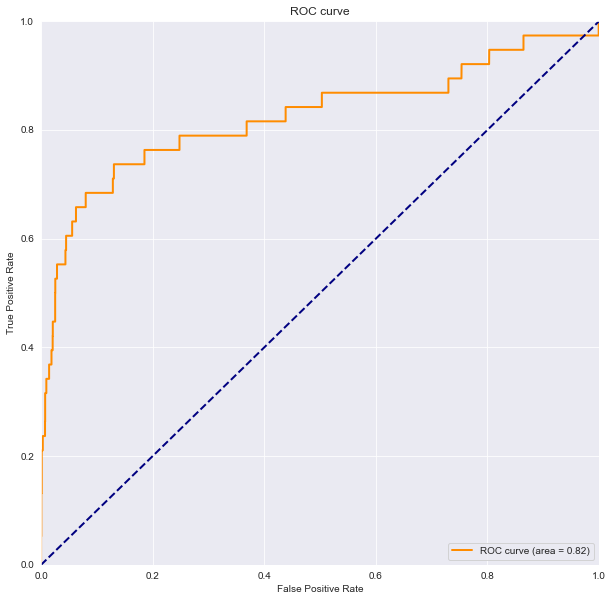

In [142]:
# 参数
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'metric': {'l2','fair'},
    'num_leaves':30,
    'num_threads':8,
    'learning_rate':0.06,
    'feature_fraction':0.6,
    'bagging_fraction':0.5,
    'bagging_freq':5,
    'verbose':0
}

print('开始训练...')
# 训练
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_dev,
               early_stopping_rounds=10)
# 保存模型
print('保存模型...')
# 保存模型到文件中
gbm.save_model('model.txt')
print('开始预测...')
# 预测
y_pred1 = gbm.predict(X_test, num_iteration = gbm.best_iteration)
# 评估
print('预估结果的rmse为:')
print(mean_squared_error(y_test, y_pred1) ** 0.5) #Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. 
#ROC curve
print('预估结果的ROC图:')
illus_roc_curve(y_test,y_pred1)

In [143]:
# 特征重要度
fi = pd.Series(gbm.feature_importance(), index = gbm.feature_name())
fi = fi.sort_values(ascending=False)
fi

TATA        37
OTHREC      36
equity      35
size        30
LVGI        30
XueIdx_3    28
SGI         28
XueIdx_1    27
lin1        26
lin2        26
cfi         25
lin_5       25
cff         24
turnover    23
XueIdx_4    23
lin_1       22
GMI         21
SGAI        21
AQI         19
DSRI        16
LOSS         0
dtype: int32

In [144]:
def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label'])
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('\nPrecision: {}'.format(Precision))
    print('Recall: {}\n'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'False':FalseNegative,'True':TrueNegative},
                    'Positive':{'False':FalsePositive,'True':TruePositive}                            
                    })      
    
    print(_confusion_matrix)
    return _confusion_matrix

In [145]:
for alpha in [0.0046,0.0047,0.00475,0.0048,0.005]:
    print( '--------- {} ---------'.format(alpha))
    pred2 = [1 if x>alpha else 0 for x in y_pred1]
    real = y_test
    confusion_matrix(pred2,real)

--------- 0.0046 ---------

Precision: 0.014787430683918669
Recall: 0.8421052631578947

       Negative  Positive
False         6      2132
True       2105        32
--------- 0.0047 ---------

Precision: 0.014904517931998137
Recall: 0.8421052631578947

       Negative  Positive
False         6      2115
True       2122        32
--------- 0.00475 ---------

Precision: 0.014967259120673527
Recall: 0.8421052631578947

       Negative  Positive
False         6      2106
True       2131        32
--------- 0.0048 ---------

Precision: 0.015016424213984044
Recall: 0.8421052631578947

       Negative  Positive
False         6      2099
True       2138        32
--------- 0.005 ---------

Precision: 0.015230842455973346
Recall: 0.8421052631578947

       Negative  Positive
False         6      2069
True       2168        32


开始预测...
预估结果的rmse为:
0.0957229976501319
预估结果的ROC图:


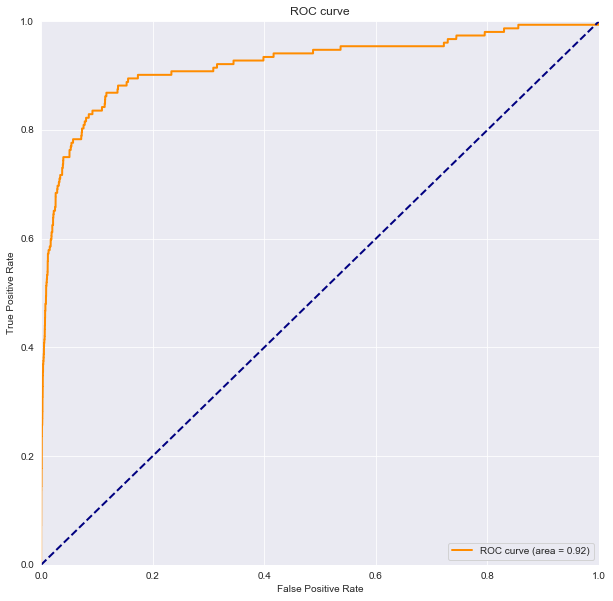

In [146]:
##########使用############
md = lgb.Booster(model_file='model.txt')
# 预测整体 
print('开始预测...')
y_pred2 = md.predict(X, num_iteration = gbm.best_iteration)
# 评估
print('预估结果的rmse为:')
print(mean_squared_error(y, y_pred2) ** 0.5) #Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. 
#ROC curve
print('预估结果的ROC图:')
illus_roc_curve(y,y_pred2)